<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [191]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [192]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [193]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [194]:
STOP_WORDS = nlp.Defaults.stop_words.union(['I','i','it','It','its',"it's",
                                            'was','they', 'of','for',
                                            'my','My','was', 'he','she',
                                            'here','where','\n','\n\n',
                                            'the','we',"i'm",'&','they',
                                            ' ','We',"I'm", "I've",'They',
                                            'The','-'])

In [195]:
def tokenize(docs):
    
    tokens = []

    for doc in tokenizer.pipe(yelp['text'], batch_size=500):

        doc_tokens = []

        for token in doc: 
            if token.text not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)
    
    return tokens

In [196]:
tokens = tokenize(yelp['text'])

yelp['tokens'] = tokens

In [197]:
yelp[['text', 'tokens']]

,text,tokens
0,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...","[beware!!!, fake,, fake,, fake....we, small, b..."
1,Came here for lunch Togo. Service was quick. S...,"[came, lunch, togo., service, quick., staff, f..."
2,I've been to Vegas dozens of times and had nev...,"[vegas, dozens, times, stepped, foot, circus, ..."
3,We went here on a night where they closed off ...,"[went, night, closed, street, party..., and, b..."
4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...","[3.5, 4, stars, not, bad, price,, $12.99, lunc..."
5,"Tasty, fast casual Latin street food. The men...","[tasty,, fast, casual, latin, street, food., m..."
6,This show is absolutely amazing!! What an incr...,"[this, absolutely, amazing!!, what, incredible..."
7,Came for the Pho and really enjoyed it! We go...,"[came, pho, enjoyed, it!, got, 9:00pm, busy, g..."
8,Absolutely the most Unique experience in a nai...,"[absolutely, unique, experience, nail, shop, f..."
9,Wow. I walked in and sat at the bar for 10 min...,"[wow., walked, sat, bar, 10, minutes., all, ba..."


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [198]:
# This is a recent review of a restaurant I used to work for. 

new_review = """A terrific meal! Primarily Spanish tapas, it's like a high end Jaleo. Service was 
                excellent. A manager asked me several times how my dinner was going. Once seated, 
                I felt well taken care of. The space is attractive. It seems airy and uncrowned 
                even though there is actually a high density of tables. The food was outstanding. 
                My favorite dish was the Atun Rojo, basically raw tuna with a little bit of artichoke, 
                red pepper, and olives; but the charcoal grilled scallops were also amazing. Perfectly 
                cooked and a relatively large portion. The one aspect that could be improved is reception. 
                Although I had a reservation and there were plenty of open tables, and they seemed well-staffed, 
                the hosts and hostesses seemed disorganized.  Whatever they are doing with iPads does not seem efficient."""

In [199]:
reviews = list(yelp['text'])
print(len(reviews))
reviews.append(new_review)
print(len(reviews))

10000
10001


In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', 
                        max_features = 5000, 
                        min_df=5)

vect = tfidf.fit_transform(reviews)
#new = tfidf.fit_transform(reviews)

In [201]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

nn.fit(vect.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [202]:
neighborhood = nn.kneighbors(vect.todense()[10000], n_neighbors=11)

In [203]:
# Closest reviews for some reason

import numpy as np
for i in np.arange(1,11):
    r_index = neighborhood[1][0][i]
    print('### Review: ',i,'###')
    print(yelp['text'][r_index][:150],'\n')

### Review:  1 ###
天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來 

### Review:  2 ###
旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。
質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 
ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。
予定になかったまつ毛エクステもお願いし、 

### Review:  3 ###
Flavors are just ok. I had red pepper bouillabaisse with scallops,  mussels and blue crab. Crab was non-existant and tasted nothing like you would exp 

### Review:  4 ###
The food was absolutely phenomenal, I got a sin city burger and it was probably the best meal I had all week. 
We (party of 6) walked in at lunch with 

### Review:  5 ###
Service & ambience: great
Food: not so much

The Toronto izakaya space is very competitive with some great tasting food.  However, this is not one of  

### Review:  6 ###
Held my wedding reception here a couple months ago and Sharon and her team did an amazing job. She blocked off half the restaurant for my guests and t 

### Review:  7 ###
I real

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [204]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


vect = TfidfVectorizer(stop_words='english')
sgdc = SGDClassifier()

pipe = Pipeline([('vect', vect), ('clf', sgdc)])

pipe.fit(yelp['text'], yelp['stars'])

pipe.predict([new_review])

array([5])

[Not bad, that was a 4-star review in reality](https://www.yelp.com/biz/del-mar-washington?hrid=BjzmlNLqJynt5s4SeixgQw&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct))

In [205]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__max_iter':(20, 10, 100)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(yelp['text'], yelp['stars'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [206]:
print('Best Accuracy:', grid_search.best_score_,'\n')

print('Best Estimator:', grid_search.best_estimator_)

Best Accuracy: 0.6088 

Best Estimator: Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                 

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [207]:
# Building LDA model with the tokens column

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
import re

id2word = corpora.Dictionary(tokens)
id2word.filter_extremes(no_below=10, no_above=0.75)
corpus = [id2word.doc2bow(text) for text in tokens]


lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [208]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[2:5]) for t in words]

In [209]:
print(topics[0])
print(words[0])

pretty good service
['place', 'best', 'pretty', 'good', 'service', 'got', 'food', 'good.', 'recommend', 'bar']


I have worked in hospitality for a long time and as a result, I have a pretty negative opinion of yelp and yelp reviewers. So I went into this Sprint Challenge with a bias as far as what results I was going to get. However, the results were pretty remarkable. 

In the industry, I tended to ignore positive reviews and focus on negative reviews. Those were things that owners and management would care about and would result in early morning emails and interrogations. Therfore I was never really aware how much positive reinforcement there was to be had. The topics hits that nail on the head. It drags out a topic talking about all the positives of an experience. So for my first visualization, I would like to compare that to a wordcount chart to see if that trend is generally representative of all the reviews. 

In [210]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

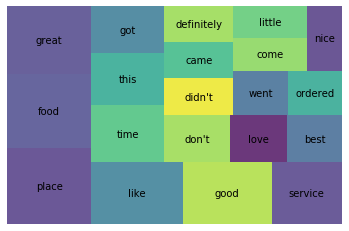

In [211]:
import squarify

wc = count(tokens)

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

You see a lot of positve terms here. "Great" is one of the most commonly used words and you have superlatives like "best" and "love" also among the top. At no point do you have negative terms, despite my implicit bias. Furthermore, the LDA chart below reinforces that with multiple topics that are related to the above topic. 

In [213]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.114329  0.008030       1        1  14.561451
3     -0.110413  0.002259       2        1  12.046046
10     0.033572  0.034741       3        1  10.173124
8     -0.060161 -0.070262       4        1   9.939737
12    -0.136716  0.039425       5        1   8.796153
2      0.088027 -0.021832       6        1   7.061737
7     -0.083488  0.040102       7        1   6.001064
13    -0.007836 -0.081532       8        1   5.844402
1      0.205567  0.071768       9        1   5.010710
9     -0.075613  0.053464      10        1   4.174451
4      0.078240 -0.075180      11        1   4.011911
6     -0.058274 -0.011117      12        1   3.943750
5      0.023835  0.051528      13        1   3.264165
0      0.012030 -0.105373      14        1   2.709689
11    -0.023097  0.063978      15        1   2.461610, topic_info=     Category         Freq        Term        Total  loglift  logprob
346   Default  3577.000000        food  3577.000000  30.0000  30.0000
196   Default  3474.000000       great  3474.000000  29.0000  29.0000
118   Default  3767.000000       place  3767.000000  28.0000  28.0000
1991  Default   496.000000         car   496.000000  27.0000  27.0000
91    Default   690.000000        room   690.000000  26.0000  26.0000
763   Default   429.000000       sushi   429.000000  25.0000  25.0000
1211  Default  1128.000000     chicken  1128.000000  24.0000  24.0000
42    Default  2554.000000     service  2554.000000  23.0000  23.0000
749   Default   385.000000       cream   385.000000  22.0000  22.0000
1198  Default  1455.000000     ordered  1455.000000  21.0000  21.0000
175   Default  1047.000000   recommend  1047.000000  20.0000  20.0000
1767  Default   300.000000       hotel   300.000000  19.0000  19.0000
29    Default  2462.000000        time  2462.000000  18.0000  18.0000
169   Default  3008.000000        good  3008.000000  17.0000  17.0000
198   Default   296.000000        hair   296.000000  16.0000  16.0000
369   Default   547.000000       pizza   547.000000  15.0000  15.0000
110   Default  1634.000000        best  1634.000000  14.0000  14.0000
1713  Default   549.000000      cheese   549.000000  13.0000  13.0000
1015  Default  1043.000000         new  1043.000000  12.0000  12.0000
753   Default   398.000000         ice   398.000000  11.0000  11.0000
43    Default  1206.000000       staff  1206.000000  10.0000  10.0000
359   Default  1426.000000      little  1426.000000   9.0000   9.0000
353   Default   903.000000          he   903.000000   8.0000   8.0000
187   Default  1793.000000       don't  1793.000000   7.0000   7.0000
1147  Default   466.000000      coffee   466.000000   6.0000   6.0000
336   Default  1456.000000  definitely  1456.000000   5.0000   5.0000
717   Default  1555.000000        love  1555.000000   4.0000   4.0000
6     Default   608.000000      called   608.000000   3.0000   3.0000
32    Default  1442.000000        came  1442.000000   2.0000   2.0000
598   Default   725.000000        work   725.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
792   Topic15    36.418560       visit   388.150879   1.3380  -5.7152
29    Topic15    83.085487        time  2462.172607   0.3154  -4.8904
346   Topic15    97.568863        food  3577.271240   0.1026  -4.7297
1252  Topic15    29.321613       today   250.497437   1.5592  -5.9319
626   Topic15    34.490124     perfect   369.695892   1.3323  -5.7696
13    Topic15    87.396423        like  3327.857422   0.0647  -4.8398
1015  Topic15    52.016602         new  1043.831055   0.7053  -5.3587
43    Topic15    54.997471       staff  1206.422119   0.6162  -5.3030
1459  Topic15    31.952282       fries   353.832275   1.2998  -5.8460
169   Topic15    74.210007        good  3008.057373   0.0022  -5.0033
42    Topic15    68.690216     service  2554.623047   0.0883  -5.0806
32    Topic15    49.937103   

In conclusion, I am jaded and definitely made the right move by leaving hospitality. Overall yelpers are positive in their outlook and generally heap praise upon establishments. 